<a href="https://colab.research.google.com/github/drbarak/Classification_shufersal/blob/main/CorrelationMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developed based on the "better heatmap" from

SOURCE: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

See also my notebook "HeatCorrelationBetter"



# NOTE: make sure all columns are numeric - non numeric colums are not included in the map

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
p = print
d = display

In [ ]:
n_colors = 256 # Use 256 colors for the diverging color palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette

def value_to_color(val):
    # step 4 - add colors
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    try: # case of float Nan
      ind = int(val_position * (n_colors - 1)) # target index in the color palette
    except ValueError:
      ind = 0
    return palette[ind]

def heatmap_static(corr, static, first):
    x=corr['x']
    y=corr['y']
    size=corr['value'].abs()
    color=corr.value
    
    # Step 1
    n = int(np.sqrt(len(x)))

    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique(), reverse=True)]
    y_labels = [v for v in sorted(y.unique(), reverse=True)]

    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 

    fig = plt.figure(figsize=(max(4, n), max(4, n / 2)))
    #ax = fig.gca()
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_yticks([y_to_num[v] for v in y_labels])
    if not first is None:
      x_labels[n-1] = y_labels[n-1] = first
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticklabels(y_labels)

    # Step 2
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    # Step 3
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    # Step 5
    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right 

#    mplcursors.cursor(hover=True)
    if not static:
      mplcursors.cursor().connect("add", lambda sel: sel.annotation.set_text(color[sel.target.index]))

    plt.show() 

## Interactive graph - point to a square and see the correlation value

### If there is an error during display of the graph, need to update plotly to at least version 4.7:

RuntimeError: dictionary changed size during iteration

So run the next cell, click on it to answer the queation 'Proceed(y/n)?' and enter 'y' and then ENTER, so th eupdate of plotly is done

In [ ]:
!pip uninstall -y plotly
!pip install plotly==4.7

Uninstalling plotly-4.4.1:
  Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 11.5MB 7.7MB/s 


In [ ]:
clear_opts = ['diagonal', 'upperleft', 'lowerleft', 'upperleftdiagonal', 'lowerleftdiagonal',
                'upperright', 'lowerright', 'upperrightdiagonal', 'lowerrightdiagonal',
                'diagonalleft','diagonalright']
def clear_corr(df, clear, nround):
  clear_opt = 0
  if clear and clear.lower() in clear_opts:
    clear_opt = clear_opts.index(clear.lower()) + 1
  #corr = df[df.columns].corr()  # n columns makes n * n correlations values
  corr = df.corr().round(nround)
  if clear_opt:
    corr = corr[sorted(df.columns, reverse=True)]
    corr = corr.loc[sorted(df.columns, reverse=False)]
    n = len(corr.columns)
    diag = 0 if clear_opt in [1,4,3,8,9,10,11] else 1
    for i in range(n):
      if clear_opt in [10]:    # diagonalleft
        corr.iloc[i, i + diag] = 0
      elif clear_opt in [6,8]:  # upperright, upperrightdiagonal 
        corr.iloc[i, i + diag:n] = 0
      elif clear_opt in [3,5]:  # lowerleft, lowerleftdiagonal
        corr.iloc[i, 0:i + diag] = 0
      elif clear_opt in [7,9]:  # lowerright, lowerrightdiagonal
        corr.iloc[i, 0: n - i - diag] = 0
      elif clear_opt in [1,11]:  # diagonal, diagonalright
        corr.iloc[i, n - i - 1] = 0
      elif clear_opt in [2,4]:  # upperleft, upperleftdiagonal
        corr.iloc[i, n - i + diag - 1: n] = 0
  return corr

# display_corr

In [ ]:
import inspect

def display_args(func):
    spec = inspect.getfullargspec(func)
    defaults = dict(zip(spec.args[::-1], (spec.defaults or ())[::-1]))
    defaults.update(spec.kwonlydefaults or {})
    print("Function 'display_corr' arguments:")
    print("\t", defaults)
    print("\n\tclear (which part of the table to erase, or None). Possible values:\n\t", clear_opts)
    print("\n\tstatic: if False it allows to click on each cell of the heatmap and see it's value")
    print("\n\tfirst: column name to appear on first row of the map")
    print("\n\tdisplay_table: if Tuue displays first 5 rows of the actual correlation table")
    print("\n\tnround: number of digits accuracy, default = 2")
    print("\n\nReturn: dataframe of correlations")    
    return

def display_corr(df=None, clear=None, display_table=True, static=True, first=None, nround=2):
  if df is None:
    return display_args(display_corr)

  # first remove all non numeric columns
  x = df.dtypes.astype(str)
  s = df.dtypes[~(x.str.contains('int|float|bool', regex=True))]
  for c in s.index:
    p(c)
    try:
      t = pd.to_numeric(df[c])
      if not re.search('int|float|bool', str(t.dtype)) is None:
        s = s.drop(c)
    except:
      s = s.drop(c)
  if len(s) > 0:
    print('NOTE: the following non-numeric columns where not included in the plot:')
    print('\t',list(s.index))
    print()
  corr = df.copy()
  for c in s.index:
    corr = corr.drop(c, axis=1)
    # force the reqested column to be first
  if not first is None:
    if first in corr:
      corr.rename({first: ' _' + first}, inplace=True, axis=1)
    else:
      p(f"Warning: {first} not in DataFrame")
      first = None
  corr = clear_corr(corr, clear, nround)
  corr_sav = corr.copy()
  if not first is None:
    corr_sav.rename({' _' + first: first}, inplace=True, axis=1)
    corr_sav.rename({' _' + first: first}, inplace=True, axis=0)
  corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
  corr.columns = ['x', 'y', 'value']

  if static:
    heatmap_static(corr, True, first)
  else:
    heatmap(corr, first)

  g1 = corr_sav.T
  g2 = g1.reindex(index=g1.index[::-1])
  g3=g2.T.reindex(index=g2.index[::-1]).T
  if display_table:
    display(g3.head())
  return g3

# Test data


In [ ]:
def get_dfa():
  dfa = pd.read_csv('https://raw.githubusercontent.com/drbarak/Project3_Model/main/bulld2.csv') 
  return dfa

In [ ]:
 if False:
  dfa = get_dfa()
  _ = display_corr(dfa, clear='LowerRightDiagonal', display_table=True, static=True, first='SalePrice')

In [ ]:
def get_dfa(fname, subdir=''):
  return pd.read_csv('https://raw.githubusercontent.com/DanielKorenDataScience/ClassificationProject/main/' + subdir + fname, usecols=[i for i in range(82) if not i in[0,8,10,12,14,16,18,20,24,26,27,48,50,52,54,56,58,62,64,65]]) 
df2 = get_dfa('Sweets.csv')
df2.head(1)

,HouseHoldID,LocationCityName,QuarterNumber,MonthNumber,WeekNumber,DayNumberInWeek,PeriodHoliday,DepartmentCode,CategoryCode,GroupCode,SubGroupCode,CompoundID,ParentProductNumber,BrandIndDesc,BrandName,VendorNumber,UnitOfMeasure,Price,Quantity,cntPrdAll,NetSaleAmountAll,NetSaleNoVatPrdLast3Months,QuantSale,cntMonths,DiscountPerUnit,isPromo,Energy,Pachmema,Natran,Helbon,Shuman,ShumanRavuy,ShumanTrans,Colastrol,SivimTzunatim,CafiotSucar,DepartmentCodeSubs,CategoryCodeSubs,GroupCodeSubs,SubGroupCodeSubs,CompoundIDSubs,ProductNumberSubs,BrandIndDescSuss,BrandNameSubs,VendorNumberSubs,UnitOfMeasureSubs,PriceSubs,NetSaleNoVatPrdSubs,QuantSaleSubs,cntMonthsSubs,DiscountPerUnitSubs,EnergySubs,PachmemaSubs,NatranSubs,HelbonSubs,ShumanSubs,ShumanRavuySubs,ShumanTransSubs,ColastrolSubs,SivimTzunatimSubs,CafiotSucarSusb,CorrelateItemStatusCode
0,1,ראשון לציון,202101,202102,202108,1,NotHoliday,10,6,700,3,-8000500249352,8000500249352,קינדר,לא מותג פרטי,914547,0.205,18.9,4,22,800.63,57747.16,0.8,16,NaN,noPromo,568.0,49.5,107.0,8.6,37.8,17.3,0.5,15.0,NaN,NaN,10,6,700,6,-8000500217740,8000500217740,קינדר,לא מותג פרטי,914547,0.086,9.9,46128.25,0.8,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
p(df2.columns)

Index(['HouseHoldID', 'LocationCityName', 'QuarterNumber', 'MonthNumber',
       'WeekNumber', 'DayNumberInWeek', 'PeriodHoliday', 'DepartmentCode',
       'CategoryCode', 'GroupCode', 'SubGroupCode', 'CompoundID',
       'ParentProductNumber', 'BrandIndDesc', 'BrandName', 'VendorNumber',
       'UnitOfMeasure', 'Price', 'Quantity', 'cntPrdAll', 'NetSaleAmountAll',
       'NetSaleNoVatPrdLast3Months', 'QuantSale', 'cntMonths',
       'DiscountPerUnit', 'isPromo', 'Energy', 'Pachmema', 'Natran', 'Helbon',
       'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol', 'SivimTzunatim',
       'CafiotSucar', 'DepartmentCodeSubs', 'CategoryCodeSubs',
       'GroupCodeSubs', 'SubGroupCodeSubs', 'CompoundIDSubs',
       'ProductNumberSubs', 'BrandIndDescSuss', 'BrandNameSubs',
       'VendorNumberSubs', 'UnitOfMeasureSubs', 'PriceSubs',
       'NetSaleNoVatPrdSubs', 'QuantSaleSubs', 'cntMonthsSubs',
       'DiscountPerUnitSubs', 'EnergySubs', 'PachmemaSubs', 'NatranSubs',
       'HelbonSubs', 'S

In [ ]:
RAW = True
# Fix Typo mistake
if RAW:
  df2.rename(columns={'OrderNumbert': 'OrderNumber','BrandIndDescSuss': 'BrandIndDescSubs', 'ProductNumberSubs': 'ParentProductNumberSubs', 
                    'NetSaleNoVatPrdSubs': 'NetSaleNoVatPrdLast3MonthsSubs', 'CafiotSucarSusb': 'CafiotSucarSubs'}, inplace=True)

In [ ]:
# Fill na
if RAW:
  df2.fillna({'QuantSale': 1, 'QuantSaleSubs': 1}, inplace=True)
  df2.fillna(0, inplace=True)

In [ ]:
# Encoding categories
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

if RAW:
  enc.fit(['PromoSusbDiffPromo', 'PromoSusbSamePromo', 'noPromo'])
  df2.isPromo = enc.transform(df2.isPromo)

In [ ]:
if RAW:
  df2['BrandIndDescSubs'] = df2.BrandIndDescSubs.astype('str')
  for col in ['LocationCityName', 'PeriodHoliday', 'BrandIndDesc', 'BrandName', 'BrandIndDescSubs', 'BrandNameSubs']:
    df2[col] = enc.fit_transform(df2[col])

In [ ]:
if RAW:
  df2['BrandIndDescSubs'] = df2.BrandIndDescSubs.astype('str')
  for col in ['LocationCityName', 'PeriodHoliday', 'BrandIndDesc', 'BrandName', 'BrandIndDescSubs', 'BrandNameSubs']:
    df2[col] = enc.fit_transform(df2[col])

In [ ]:
# Combine 'GroupCode' and 'SubGroupCode' into one column
if RAW:
  df2.GroupCode = df2.GroupCode * 10 + df2.SubGroupCode
  df2.GroupCodeSubs = df2.GroupCodeSubs * 10 + df2.SubGroupCodeSubs

In [ ]:
# Use Dummies
# Converting the categories column (isPromo) to dummies column 
if RAW:
  df2 = pd.get_dummies(df2, columns=['isPromo', 'PeriodHoliday'])

# Test

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54460 entries, 0 to 54459
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   OrderNumber                     54460 non-null  int64  
 1   HouseHoldID                     54460 non-null  int64  
 2   LocationCityName                54460 non-null  int64  
 3   QuarterNumber                   54460 non-null  int64  
 4   MonthNumber                     54460 non-null  int64  
 5   WeekNumber                      54460 non-null  int64  
 6   DayNumberInWeek                 54460 non-null  int64  
 7   TransactionDate                 54460 non-null  object 
 8   DepartmentCode                  54460 non-null  int64  
 9   DepartmentName                  54460 non-null  object 
 10  CategoryCode                    54460 non-null  int64  
 11  CategoryName                    54460 non-null  object 
 12  GroupCode                       

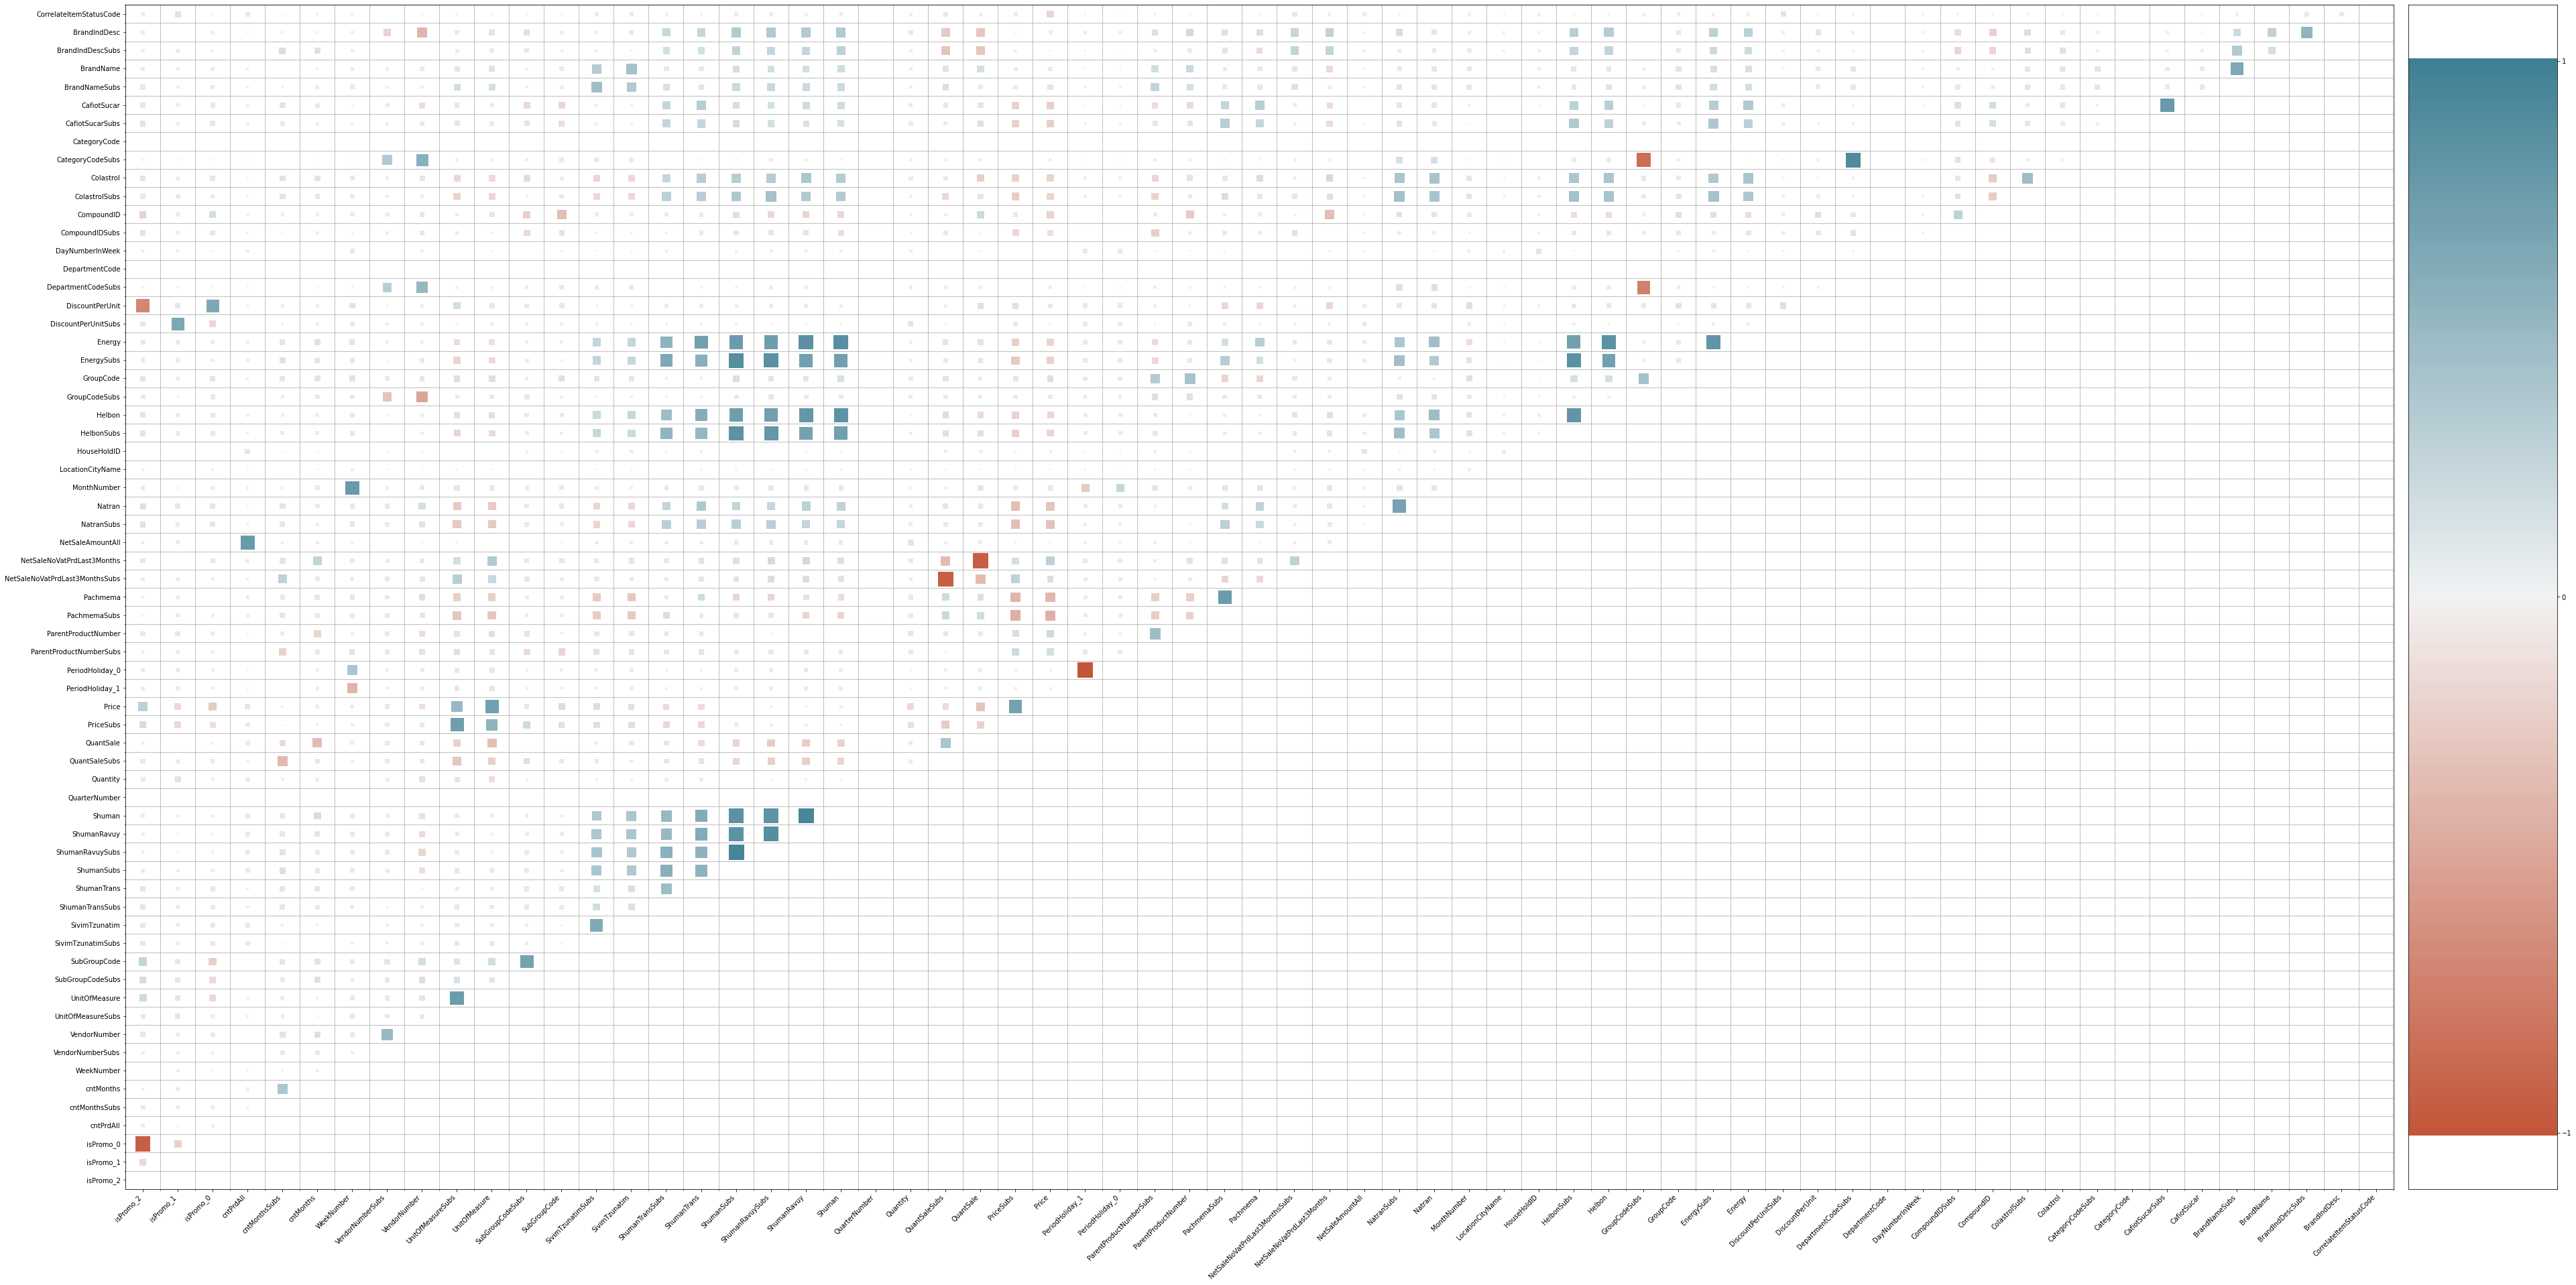

,isPromo_2,isPromo_1,isPromo_0,cntPrdAll,cntMonthsSubs,cntMonths,WeekNumber,VendorNumberSubs,VendorNumber,UnitOfMeasureSubs,UnitOfMeasure,SubGroupCodeSubs,SubGroupCode,SivimTzunatimSubs,SivimTzunatim,ShumanTransSubs,ShumanTrans,ShumanSubs,ShumanRavuySubs,ShumanRavuy,Shuman,QuarterNumber,Quantity,QuantSaleSubs,QuantSale,PriceSubs,Price,PeriodHoliday_1,PeriodHoliday_0,ParentProductNumberSubs,ParentProductNumber,PachmemaSubs,Pachmema,NetSaleNoVatPrdLast3MonthsSubs,NetSaleNoVatPrdLast3Months,NetSaleAmountAll,NatranSubs,Natran,MonthNumber,LocationCityName,HouseHoldID,HelbonSubs,Helbon,GroupCodeSubs,GroupCode,EnergySubs,Energy,DiscountPerUnitSubs,DiscountPerUnit,DepartmentCodeSubs,DepartmentCode,DayNumberInWeek,CompoundIDSubs,CompoundID,ColastrolSubs,Colastrol,CategoryCodeSubs,CategoryCode,CafiotSucarSubs,CafiotSucar,BrandNameSubs,BrandName,BrandIndDescSubs,BrandIndDesc,CorrelateItemStatusCode
CorrelateItemStatusCode,-0.04,0.12,-0.01,0.08,0.01,0.02,-0.02,0.00,-0.01,-0.01,0.01,-0.01,-0.01,-0.06,-0.06,-0.03,-0.01,-0.05,-0.04,-0.03,-0.04,NaN,-0.03,-0.08,-0.03,-0.05,-0.17,-0.01,0.01,0.02,0.01,-0.00,-0.01,0.08,0.03,0.05,-0.01,0.00,-0.03,0.01,0.03,-0.01,0.01,0.03,0.04,-0.03,-0.03,0.11,-0.01,-0.01,NaN,-0.01,0.02,0.02,0.02,-0.01,-0.01,NaN,0.00,-0.01,-0.03,0.00,0.07,0.06,0.0
BrandIndDesc,0.05,-0.00,-0.04,0.01,0.02,0.02,-0.02,-0.19,-0.38,0.06,0.12,-0.13,-0.04,0.03,0.07,0.24,0.25,0.36,0.36,0.35,0.36,NaN,-0.07,-0.26,-0.27,0.01,0.05,-0.04,0.04,0.13,0.20,-0.13,-0.15,0.25,0.28,-0.01,0.17,0.10,-0.03,-0.02,0.02,0.32,0.34,0.00,0.08,0.30,0.30,-0.03,-0.11,0.03,NaN,0.02,-0.14,-0.20,0.15,0.08,0.03,NaN,-0.03,0.01,0.20,0.29,0.54,0.00,0.0
BrandIndDescSubs,-0.04,0.05,0.02,0.00,0.16,0.14,-0.04,0.00,-0.00,0.05,0.06,-0.06,-0.02,0.03,-0.01,0.18,0.18,0.27,0.25,0.25,0.29,NaN,-0.03,-0.29,-0.28,-0.02,0.01,-0.01,0.01,0.04,0.07,-0.11,-0.13,0.27,0.27,-0.02,0.05,0.06,-0.06,-0.02,0.03,0.25,0.27,0.00,0.07,0.21,0.20,0.02,-0.02,0.02,NaN,0.02,-0.17,-0.17,0.14,0.13,0.03,NaN,-0.02,-0.04,0.35,0.18,0.00,0.00,0.0
BrandName,0.06,-0.03,-0.05,-0.02,0.00,0.02,0.04,0.04,0.07,0.10,0.13,0.02,0.07,0.34,0.43,0.08,0.08,0.18,0.18,0.18,0.19,NaN,-0.03,0.12,0.18,0.05,0.06,0.01,-0.01,0.19,0.21,-0.06,-0.08,-0.09,-0.15,-0.01,-0.08,-0.09,0.08,0.00,-0.03,0.10,0.09,-0.04,0.11,0.16,0.16,0.01,0.07,0.10,NaN,0.02,-0.03,-0.02,-0.09,-0.11,0.11,NaN,0.06,0.07,0.65,0.00,0.00,0.00,0.0
BrandNameSubs,0.08,-0.03,-0.06,-0.02,-0.01,0.05,0.07,0.02,0.03,0.17,0.16,0.03,0.05,0.45,0.36,0.15,0.11,0.21,0.22,0.21,0.21,NaN,-0.03,0.15,0.07,0.06,0.11,-0.02,0.02,0.27,0.16,-0.07,-0.09,-0.13,-0.05,-0.01,-0.11,-0.10,0.10,-0.00,-0.03,0.09,0.12,-0.04,0.12,0.18,0.17,0.00,0.07,0.09,NaN,0.02,-0.08,-0.04,-0.11,-0.08,0.10,NaN,0.07,0.08,0.00,0.00,0.00,0.00,0.0


In [ ]:
df = display_corr(df2, clear='LowerRightDiagonal', display_table=True, static=True, first='CorrelateItemStatusCode')

In [ ]:
s = df.T.CorrelateItemStatusCode.abs()
s.sort_values(ascending=False).head(20)

Price                             0.17
isPromo_1                         0.12
DiscountPerUnitSubs               0.11
cntPrdAll                         0.08
NetSaleNoVatPrdLast3MonthsSubs    0.08
QuantSaleSubs                     0.08
BrandIndDescSubs                  0.07
SivimTzunatimSubs                 0.06
SivimTzunatim                     0.06
BrandIndDesc                      0.06
PriceSubs                         0.05
NetSaleAmountAll                  0.05
ShumanSubs                        0.05
GroupCode                         0.04
isPromo_2                         0.04
Shuman                            0.04
ShumanRavuySubs                   0.04
QuantSale                         0.03
MonthNumber                       0.03
ShumanRavuy                       0.03
Name: CorrelateItemStatusCode, dtype: float64